In [1]:
%load_ext autoreload
%autoreload 2

import random
import anaconfig
import os
import os.path as op

import numpy.typing as npt
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from utils.commonutils.crun import run_for_different_partitions
from utils.commonutils.config import (
    get_pipeline_config_path,cdirs, load_config, resolve_config_paths
)
from utils.commonutils.ctests import get_required_test_dataset_names
from utils.plotutils.plotconfig import configure_matplotlib
from scripts.evaluate import evaluate_partition

configure_matplotlib()


In [2]:
partition = "minbias-sim10b-xdigi_v2.4_1498"
experiment_name = "scifi-3-xuvx-naive"

config_path = get_pipeline_config_path(experiment_name)
config = load_config(config_path)
data_experiment_dir = op.join(
    cdirs.data_directory, config["common"]["experiment_name"]
)

In [3]:
from Embedding.models.layerless_embedding import LayerlessEmbedding
from utils.modelutils import checkpoint_utils

embedding_version_dir = checkpoint_utils.get_last_version_dir_from_config(
    step="metric_learning", path_or_config=config_path,
)
embedding_metric_path = op.join(embedding_version_dir, "metrics.csv")
embedding_artifact_path = checkpoint_utils.get_last_artifact(
    version_dir=embedding_version_dir
)
print(f"{embedding_metric_path=}")
print(f"{embedding_artifact_path=}")

metric_learning_model = LayerlessEmbedding.load_from_checkpoint(
    embedding_artifact_path,
    hparams=config["metric_learning"],
    map_location="cuda",
)


INFO:Created a temporary directory at /tmp/tmpfa4o_ov_
INFO:Writing /tmp/tmpfa4o_ov_/_remote_module_non_scriptable.py
INFO:Loading faiss with AVX2 support.
INFO:Successfully loaded faiss with AVX2 support.
INFO:init


embedding_metric_path='/home/acorreia/etx4velo/etx4velo/artifacts/metric_learning/scifi-3-xuvx-naive/version_1/metrics.csv'
embedding_artifact_path='/home/acorreia/etx4velo/etx4velo/artifacts/metric_learning/scifi-3-xuvx-naive/version_1/checkpoints/epoch=85-step=462250.ckpt'


In [4]:
metric_learning_model.bidir

False

In [6]:
from Processing.planewise_edges import get_planewise_edges

# Load one event
batch_dir = op.join(data_experiment_dir, "processed", "test", partition)
filenames = [file_.path for file_ in os.scandir(batch_dir) if file_.is_file and file_.name != "done"]
path = filenames[random.randint(0, len(filenames))]

batch = torch.load(path, map_location="cuda")


df_particles = pd.read_parquet(batch.truncated_path + "-particles.parquet", columns=["particle_id", "eta"])
df_particles["in_acceptance"] = (df_particles["eta"] > 2.0) & (df_particles["eta"] < 5.0)


In [7]:
outputs = metric_learning_model.inference(
    batch=batch,
    squared_distance_max=0.01,
    k_max=150,
    evaluate=False,
    log=False,
)
edge_indices = outputs["edge_indices"]
y_truth = outputs["y_truth"]
batch["edge_index"] = edge_indices
batch["y"] = y_truth
batch = batch.cpu()

/home/acorreia/mambaforge/envs/etx4velo/lib/python3.10/site-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)


In [8]:
batch["plane"][batch["edge_index"]]

tensor([[ 0,  0,  0,  ..., 10, 10, 10],
        [ 1,  1,  1,  ..., 11, 11, 11]])

In [9]:
# Dataframe of hits
df_hits = pd.DataFrame(
    {
        "hit_idx": np.arange(batch["x"].shape[0]),
        "plane": batch["plane"].numpy(),
        **{column: batch[column].numpy() for column in ["xatyeq0", "zatyeq0", "dxdy"]}
    }
)

df_hits_particles = pd.DataFrame(
    {
        "particle_id": batch["particle_id_hit_idx"][:, 0].numpy(),
        "hit_idx": batch["particle_id_hit_idx"][:, 1].numpy(),
    }
)
df_hits_particles = df_hits_particles.merge(
    df_particles,
    on="particle_id",
    how="left",
)
df_hits_particles = df_hits_particles.merge(
    df_hits,
    on="hit_idx",
)

In [10]:
def get_df_edges(
    edge_indices: npt.ArrayLike,
    df_hits: pd.DataFrame,
    **kwargs,
) -> pd.DataFrame:
    edge_indices = np.asarray(edge_indices)
    df_edges = pd.DataFrame(
        {
            "hit_idx_left": edge_indices[0],
            "hit_idx_right": edge_indices[1],
            **kwargs,
        },
    )

    # Add particle ID information
    for side in ["left", "right"]:
        df_edges = df_edges.merge(
            df_hits.rename(  # type: ignore
                columns={column: f"{column}_{side}" for column in df_hits.columns}
            ),
            on=f"hit_idx_{side}",
            how="left",
        )

    return df_edges

df_edges = get_df_edges(
    edge_indices=batch["edge_index"].numpy(),
    df_hits=df_hits,
    y=batch["y"].numpy(),
)

df_true_edges = get_df_edges(
    edge_indices=batch["signal_true_edges"].numpy(),
    df_hits=df_hits_particles,
)
df_true_edges = df_true_edges[df_true_edges["particle_id_left"] == df_true_edges["particle_id_right"]]
for column in ["particle_id", "in_acceptance", "eta"]:
    df_true_edges[column] = df_true_edges[f"{column}_left"]
    df_true_edges.drop([f"{column}_{side}" for side in ("left", "right")], axis=1, inplace=True)


In [14]:
plane = 7
plane_range = 12
n_hits = 3

rng = np.random.default_rng()

# Restrain to plane range
df_edges_within_range = df_edges[
    (df_edges["plane_left"] == plane)
    # & (df_edges["plane_right"] >= plane + 1)
    # & (df_edges["plane_right"] <= plane + plane_range)
]

df_true_edges_within_range = df_true_edges[
    (df_true_edges["plane_left"] == plane)
    # (df_true_edges["plane_right"] >= plane + 1)
    # (df_true_edges["plane_right"] <= plane + plane_range)
]

df_hits_within_range = df_hits[
    (df_hits["plane"] >= plane) & (df_hits["plane"] <= plane + plane_range)
]
df_hits_with_range = df_hits

# Select `n_hits` random hits
hit_indices = df_hits_within_range[df_hits_within_range["plane"] == plane]["hit_idx"].unique()
chosen_hit_indices = hit_indices[rng.integers(low=0, high=hit_indices.shape[0], size=(n_hits,))]

hit_idx_left  hit_idx_right     y  plane_left  xatyeq0_left  \
100629          2620           2961  True           7      -1209.19   

        zatyeq0_left  dxdy_left  plane_right  xatyeq0_right  zatyeq0_right  \
100629        8717.9       -0.0            8       -1400.27         9193.1   

        dxdy_right  
100629        -0.0

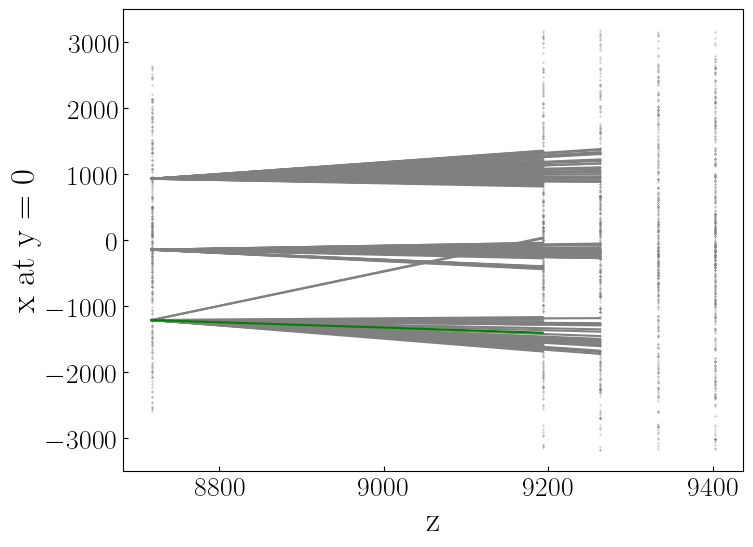

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(
    df_hits_within_range["zatyeq0"],
    df_hits_within_range["xatyeq0"],
    color="grey",
    linestyle="",
    marker=".",
    markersize=0.5,
)

df_chosen_edges = df_edges_within_range[
    df_edges_within_range["hit_idx_left"].isin(chosen_hit_indices)
]

for _, edge in df_chosen_edges.iterrows():
    ax.plot(
        [edge["zatyeq0_left"], edge["zatyeq0_right"]],
        [edge["xatyeq0_left"], edge["xatyeq0_right"]],
        color="green" if edge["y"] else "grey",
        zorder=10000 if edge["y"] else None,
    )

ax.set_xlabel("z")
ax.set_ylabel("x at y = 0")
df_chosen_edges[df_chosen_edges["y"]]

In [16]:
df_edges_within_range


hit_idx_left  hit_idx_right      y  plane_left  xatyeq0_left  \
84949           2388           2750  False           7      -2589.69   
84950           2388           2751  False           7      -2589.69   
84951           2388           2752  False           7      -2589.69   
84952           2388           2753   True           7      -2589.69   
84953           2388           2754  False           7      -2589.69   
...              ...            ...    ...         ...           ...   
109304          2749           3493  False           7       2640.98   
109305          2749           3494  False           7       2640.98   
109306          2749           3495  False           7       2640.98   
109307          2749           3496  False           7       2640.98   
109308          2749           3497  False           7       2640.98   

        zatyeq0_left  dxdy_left  plane_right  xatyeq0_right  zatyeq0_right  \
84949         8717.9        0.0            8       -3132.16         9193.1   
84950         8717.9        0.0            8       -3098.71         9193.1   
84951         8717.9        0.0            8       -2904.76         9193.1   
84952         8717.9        0.0            8       -2801.16         9193.1   
84953         8717.9        0.0            8       -2554.99         9193.1   
...              ...        ...          ...            ...            ...   
109304        8717.9       -0.0            9        3056.58         9262.9   
109305        8717.9       -0.0            9        3087.77         9262.9   
109306        8717.9       -0.0            9        3105.19         9262.9   
109307        8717.9       -0.0            9        3106.07         9262.9   
109308        8717.9       -0.0            9        3184.24         9262.9   

        dxdy_right  
84949     0.000000  
84950     0.000000  
84951     0.000000  
84952     0.000000  
84953     0.000000  
...            ...  
109304    0.087489  
109305    0.087489  
109306    0.087489  
109307    0.087489  
109308    0.087489  

[24360 rows x 11 columns]

In [22]:
# Select `n_hits` random hits
hit_indices = df_true_edges_within_range["hit_idx_left"].unique()
chosen_hit_indices = hit_indices[rng.integers(low=0, high=hit_indices.shape[0], size=(40,))]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(
    df_hits_within_range["zatyeq0"],
    df_hits_within_range["xatyeq0"],
    color="grey",
    linestyle="",
    marker=".",
    markersize=0.5,
)

for _, edge in df_true_edges_within_range[df_true_edges_within_range["hit_idx_left"].isin(chosen_hit_indices)].iterrows():
    ax.plot(
        [edge["zatyeq0_left"], edge["zatyeq0_right"]],
        [edge["xatyeq0_left"], edge["xatyeq0_right"]],
        color="green" if edge["in_acceptance"] else "red",
    )


ValueError: high <= 0

In [94]:
chosen_hit_indices

array([457, 527, 493, 429, 481, 503, 533, 502, 470, 466, 481, 513, 518,
       517, 542, 445, 514, 506, 533, 480])